# **Breakpoints**
Review
For human-in-the-loop, we often want to see our graph outputs as its running.

We laid the foundations for this with streaming.

# **Goals**
Now, let's talk about the motivations for human-in-the-loop:

(1) Approval - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) Debugging - We can rewind the graph to reproduce or avoid issues

(3) Editing - You can modify the state

LangGraph offers several ways to get or update agent state to support various human-in-the-loop workflows.

First, we'll introduce breakpoints, which provide a simple way to stop the graph at specific steps.

We'll show how this enables user approval.

In [1]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file with UTF-8 encoding
load_dotenv(encoding='utf-8')

# Get the API key from environment
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# **Breakpoints for human approval**
Let's re-consider the simple agent that we worked with in Module 1.

Let's assume that are concerned about tool use: we want to approve the agent to use any of its tools.

All we need to do is simply compile the graph with interrupt_before=["tools"] where tools is our tools node.

This means that the execution will be interrupted before the node tools, which executes the tool call.

In [7]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b
def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

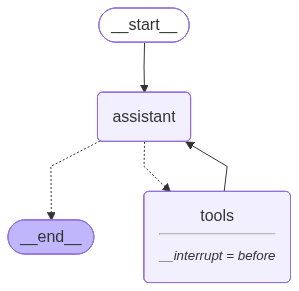

In [8]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
memory = MemorySaver()
graph = builder.compile(interrupt_before=["tools"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [9]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_t7ICpNuGSJscw7HQn7sTpkXR)
 Call ID: call_t7ICpNuGSJscw7HQn7sTpkXR
  Args:
    a: 2
    b: 3


We can get the state and look at the next node to call.

This is a nice way to see that the graph has been interrupted.

In [10]:
state = graph.get_state(thread)
state.next

('tools',)

Now, we'll introduce a nice trick.

When we invoke the graph with None, it will just continue from the last state checkpoint!

For clarity, LangGraph will re-emit the current state, which contains the AIMessage with tool call.

And then it will proceed to execute the following steps in the graph, which start with the tool node.

We see that the tool node is run with this tool call, and it's passed back to the chat model for our final answer.

In [11]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (call_t7ICpNuGSJscw7HQn7sTpkXR)
 Call ID: call_t7ICpNuGSJscw7HQn7sTpkXR
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


Now, lets bring these together with a specific user approval step that accepts user input.

In [12]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

# Get user feedback
user_approval = input("Do you want to call the tool? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":
    
    # If approved, continue the graph execution
    for event in graph.stream(None, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()
        
else:
    print("Operation cancelled by user.")

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_DK3Ibsh9fUyd5aiRXcBpqyjh)
 Call ID: call_DK3Ibsh9fUyd5aiRXcBpqyjh
  Args:
    a: 2
    b: 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_DK3Ibsh9fUyd5aiRXcBpqyjh)
 Call ID: call_DK3Ibsh9fUyd5aiRXcBpqyjh
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.
